# EDA for DietDupe

### load the data

In [86]:
import pickle
import pandas as pd

# load the data of node embeddings in FlavourGraph
with open('data/FlavorGraph_node_embedding.pickle', 'rb') as f:
    data = pickle.load(f)

# cast node_ids to integer
data = {int(k): v for k, v in data.items()}


In [87]:
# read information abo
nodes= pd.read_csv('data/nodes_191120.csv')

#delete nan in node name column
nodes = nodes.dropna(subset=['name'])

# make sure name is a string
nodes['name'] = nodes['name'].astype(str)

nodes.head()

,node_id,name,id,node_type,is_hub
0,0,1%_fat_buttermilk,NaN,ingredient,no_hub
1,1,1%_fat_cottage_cheese,NaN,ingredient,no_hub
2,3,10%_cream,NaN,ingredient,no_hub
3,4,100%_bran,NaN,ingredient,no_hub
4,5,10_inch_flour_tortilla,NaN,ingredient,no_hub


In [88]:
# merge the dataframe and dictionnary by name and display projection
nodes['embeddings'] = nodes['node_id'].map(data)

In [89]:
nodes.head()

,node_id,name,id,node_type,is_hub,embeddings
0,0,1%_fat_buttermilk,NaN,ingredient,no_hub,"[-0.10600116, 0.047149494, 0.10841199, 0.07235..."
1,1,1%_fat_cottage_cheese,NaN,ingredient,no_hub,"[-0.015829312, 0.09736368, -0.0006226096, 0.13..."
2,3,10%_cream,NaN,ingredient,no_hub,"[-0.10132008, 0.033723958, 0.064727835, 0.1566..."
3,4,100%_bran,NaN,ingredient,no_hub,"[-0.10309663, 0.03204953, 0.08858223, 0.105722..."
4,5,10_inch_flour_tortilla,NaN,ingredient,no_hub,"[-0.09346332, 0.120890595, 0.10606088, 0.10007..."


## Our first extrenal dataset will concern the kcal and nutritional values for foods - for example for the search of a lower calorie alternative of a food, or richer in a certain vitamin group

In [90]:
# calories dataset
nutri_data= pd.read_csv('data/ABBREV.csv')
nutri_data.head()

,index,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),...,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
0,0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,...,7.0,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1,1,1002,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,...,4.6,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
2,2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,...,8.6,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup,0.0
3,3,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,...,2.4,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch,0.0
4,4,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,...,2.5,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded",0.0


## Preprocessing (expand abbrevs, split words, lemmatization, etc.)

In [91]:
import re
import enchant
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

en_dict = enchant.Dict("en_US")
word_whitelist_regex = re.compile(r"\d+%?")
def is_english_word(s: str) -> bool:
    return en_dict.check(s) or word_whitelist_regex.match(s)

nltk.download("stopwords")
nltk.download("wordnet")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Hard-coded, hand-made regex for splitting words
split_regex = re.compile(r"[|,\s()&_]+|w/")

def preprocess(desc: str) -> str:
    tokens = split_regex.split(desc.lower())  # Lower case and split words

    # Remove stuff like "without salt" or "wo/salt" (just don't list salt, low relevance)
    tokens_new = []
    i = 0
    while i < len(tokens):
        if tokens[i] in ("without", "w/o", "wo/"): 
            i += 2  # skip the next token
            continue
        if tokens[i].startswith("w/") :
            i += 1
            tokens_new.append('with')
            continue
        if tokens[i].startswith("wo/") :
            i += 2  # skip the next token
            continue
        tokens_new.append(tokens[i])
        i += 1
    tokens = tokens_new
    
    # Expand abbreviations
    tokens_new = []
    for token in tokens:
        if token in abbrev_map:
            tokens_new.extend(split_regex.split(abbrev_map[token].lower()))
        else:
            tokens_new.append(token)
    tokens = tokens_new
            
    tokens = filter(len, tokens)                # Filter out empty words
    tokens = list(tokens)

    # Save all non-english words and their contexts for later summary
    # (helps for manually extending abbrev_map)
    for token in filter(lambda x: not is_english_word(x), tokens):
        if token not in unknown_abbreviations:
            unknown_abbreviations[token] = set()
        unknown_abbreviations[token].add(desc)
            
    tokens = map(lemmatizer.lemmatize, tokens)  # Apply lemmatization
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ismyn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ismyn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [92]:
# Print unknown abbreviations summary (optional)
def print_unknown_abbreviations(first_n: int = 100) -> None:
    # Sort by the number of contexts in which it they occurred
    unknown_abbrevs_list = list(unknown_abbreviations.items())
    unknown_abbrevs_list.sort(key=lambda x: len(x[1]), reverse=True)
    
    print(f"Unknown abbreviations (total contexts: {sum(len(x[1]) for x in unknown_abbrevs_list)}):")
    for i, (token, context) in enumerate(unknown_abbrevs_list, 1):
        print(f"{i}.  '{token}'  ({len(context)} contexts)")
        for desc in list(context)[:min(10, len(context))]:  # Only show up to 10 contexts for readability
            print("\t", desc)
        if i == first_n:
            break

# WORKFLOW:
# 1. Apply preprocessing
# 2. Print this summary
# 3. Inspect unknown abbreviations, try to decipher some, update abbrev_map.
#    - https://www.allacronyms.com/DRND/food
#    - https://nutritioncalc3.mheducation.com/ncplus3/resources/abbrev.pdf
# 4. Repeat

### nodes

In [93]:
abbrev_map = {}
unknown_abbreviations = {}
nodes["clean_name"] = nodes["name"].apply(preprocess)

In [94]:
print_unknown_abbreviations()

Unknown abbreviations (total contexts: 2238):
1.  'italian'  (64 contexts)
	 sweet_italian_sausage
	 italian_roll
	 hot_italian_sausage
	 good_seasonings_italian_salad_dressing_mix
	 reduced_calorie_italian_dressing
	 kraft_zesty_italian_dressing
	 italian_spice
	 italian_style_stewed_tomato
	 italian_style_tomato
	 canned_italian_tomato
2.  'chile'  (38 contexts)
	 dried_new_mexico_chile
	 canned_chipotle_chile
	 dried_ancho_chile_powder
	 dried_thai_chile
	 ground_pasilla_chile_powder
	 mild_chile
	 ground_habanero_chile_pepper
	 canned_diced_green_chile
	 pure_chile_powder
	 chipotle_chile_in_adobo
3.  '-'  (32 contexts)
	 9-Octadecenal,_(9E)-
	 (-)-cis-Carveol
	 (-)-Mintlactone
	 (-)-alpha-Terpineol
	 (-)-Epigallocatechin_gallate
	 Cyclohexene,_4-ethenyl-4-methyl-3-(1-methylethenyl)-1-(1-methylethyl)-,_(3R-trans)-
	 (-)-Zingiberene
	 2,4,7-Tridecatrienal,_(E,Z,Z)-
	 Azulene,_1,2,3,4,5,6,7,8-octahydro-1,4-dimethyl-7-(1-methylethenyl)-,_(1S,4S,7R)-
	 (-)-alpha-Pinene
4.  'chinese'  (

In [95]:
nodes[["name", "clean_name"]]

,name,clean_name
0,1%_fat_buttermilk,1% fat buttermilk
1,1%_fat_cottage_cheese,1% fat cottage cheese
2,10%_cream,10% cream
3,100%_bran,100% bran
4,10_inch_flour_tortilla,10 inch flour tortilla
...,...,...
8293,Procyanidin_B2,procyanidin b2
8294,Procyanidin_C,procyanidin c
8295,6-Keto-28-homobrassinolide,6-keto-28-homobrassinolide
8296,Anthocyanidins,anthocyanidins


### nutri_data

In [96]:
# Hard-coded, hand-made list of abbreviation expansions for ABBREV.csv
abbrev_map = {
    "w/": "with",
    "lrg": "large",
    "sml": "small",
    "crmd": "creamed",
    "uncrmd": "",
    "lowfat": "low fat",
    "milkfat": "milk fat",
    "ckd": "cooked",
    "cnd": "canned",
    "frz": "frozen",
    "rstd": "roasted",
    "bnless": "boneless",
    "bld": "boiled",
    "frsh": "fresh",
    "ln": "lean",
    "brst": "breast",
    "babyfood": "baby food",
    "choic": "choice",
    "whl": "whole",
    "h2o": "water",
    "drnd": "drained",
    "skn": "skin",
    "brsd": "braised",
    "pan-fried": "fried",
    "chs": "chips",
    "grds": "grades",
    "stmd": "steamed",
    "unprep": "unprepared",
    "rnd": "round",
    "nz": "",  # stands for New Zealand as far as I can tell; not relevant?
    "brld": "broiled",
    "juc": "juice",
    "sel": "select",  # not very sure, but it seems plausible (https://www.usda.gov/media/blog/2013/01/28/whats-your-beef-prime-choice-or-select)
    "shldr": "shoulder",
    "crm": "cream",
    "stk": "steak",
    "pln": "plain",
    "pdr": "powder",
    "cond": "condensed",
    "sau": "sauce",
    "bev": "beverage",
    "condmnt": "condiment",
    "soybn": "soybean",
    "rst": "roast",
    'lt': 'light',
    'lo': 'low',
    'na': 'sodium',
    'dom': 'domestic',
    'sndwch': 'sandwich',
    'swt': 'sweet',
    'drk': 'drink',
    'mxd': 'mixed',
    'appl': 'apple',
    'choc': 'chocolate',
    'bkd': 'baked',
    'bns': 'beans',
    'rts': 'ready-to-serve',
    'enr': 'enriched',
    'flr': 'flour',
    'vit': 'vitamin',
    'str': 'strawberry',
    'grn': 'green',
    'crl': 'cereal',
    'rtl': 'retail',
    'quaker': 'quaker (brand)',
    'kashi': 'kashi (brand)',
    'bnls': 'boneless',
    'yel': 'yellow',
    'mcdonald\'s': 'mcdonald\'s (brand)',
    'drsng': 'dressing',
    'cntr': 'center',
    'unswtnd': 'unsweetened',
    'dk': 'dark',
    'unenr': 'unenriched',
    'cinn': 'cinnamon',
    'pnut': 'peanut',
    'commly': 'commonly',
    'kellogg': 'kellogg',
    'eq': 'equal',
    'shrt': 'short',
    'htd': 'heated',
    'frstd': 'frosted',
    'bttm': 'bottom',
    'sp': 'species',
    'unhtd': 'unheated',
    'prot': 'protein',
    'lofat': 'low fat',
    'usda': 'united states department of agriculture',
    'conc': 'concentrate',
    'soln': 'solution',
    'chk': 'chuck',
    'swtnd': 'sweetened',
    'rtf': 'ready to feed',
    'stwd': 'stewed',
    'morningstar': 'morningstar farms (brand)',
    'grld': 'grilled',
    'lip-on': 'lip-on',
    'sprd': 'spread',
    'hvy': 'heavy',
    'btld': 'bottled',
    'nat': 'natural',
    'tstd': 'toasted',
    'chinese': 'chinese',
    'spl': 'special',
    'drumstk': 'drumstick',
    'snackfood': 'snack food',
    'dssrt': 'dessert',
    'johnson': 'johnson',
    'nutr': 'nutrient',
    'eggo': 'eggo (brand)',
    'brkfst': 'breakfast',
    'krnls': 'kernels',
    'dha': 'docosahexaenoic acid',
    'cocnt': 'coconut',
    'immat': 'immature',
    'murray': 'murray (brand)',
    'ara': 'arachidonic acid',
    'refr': 'refrigerated',
    'stks': 'sticks',
    'simmrd': 'simmered',
    'malt-o-meal': 'cereal',
    'v8': 'vegetable juice',
    'stk/rst': 'steak or roast',
    'hydr': 'hydrated',
    'bttrmlk': 'buttermilk',
    'flav': 'flavor',
    'enfamil': 'infant formula',
    'gluten-free': 'gluten-free',
    'atlantic': 'Atlantic',
    'pepperidge': 'Pepperidge Farm',
    'rtd': 'ready-to-drink',
    'pop-tarts': 'Pop-Tarts',
    'chopd': 'chopped',
    'cheez-it': 'Cheez-It',
    'pudd': 'pudding',
    'bbq': 'barbecue',
    'pnuts': 'peanuts',
    'pnappl': 'pineapple',
    'art': 'artificial',
    'swtnr': 'sweetener',
    'cttnsd': 'cottonseed',
    'frstng': 'frosting',
    'rtb': 'ready-to-bake',
    'coatd': 'coated',
    'asprt': 'aspartame',
    'rth': 'ready-to-heat',
    'tlc': 'tasty little crackers',
    'cheeseburger;': 'cheeseburger',
    "'n'": 'and',
    'wgu': 'wagyu',
    "denny's": "denny's",
    'bsd': 'based',
    'simil': 'similac',
    'grns': 'greens',
    'wntr': 'winter',
    'fd': 'food',
    'todd': 'toddler',
    'unckd': 'uncooked',
    'sirl': 'sirloin',
    'carb': 'carbonated',
    'rw': "raw",
    'smmr': "summer",
    'bnl': "boneless",
    'aus': 'australian',
    'cmdty': 'commodity.',
    'lttc': 'lettuce',
    'au': 'with juice',
    'chck': "meat chuck",
    'marshmllw': 'marshmallow.',
    'wht': 'white',
    'imitn': 'imitation',
    'grd': 'ground',
    'tp': 'top',
    'und': 'undercut'
}


In [97]:
unknown_abbreviations = {}
nutri_data["Clean_Desc"] = nutri_data["Shrt_Desc"].apply(preprocess)

In [98]:
print_unknown_abbreviations()

Unknown abbreviations (total contexts: 4538):
1.  'campbell's'  (171 contexts)
	 GRAVY,CAMPBELL'S,BF,FAT FREE
	 CAMPBELL'S HEALTHY REQUEST,CHICK NOODLE SOUP,COND
	 CAMPBELL'S RED&WHITE,CHICK BROTH,COND
	 CAMPBELL'S RED & WHITE,BF BROTH,COND
	 CAMPBELL'S SOUP ON THE GO,CHEESY POTATO W/ BACON FLAVOR SOUP
	 CAMPBELL'S HOMESTYLE MICROWAVEABLE BOWLS,HEALTHY REQUEST ITA
	 CAMPBELL'S SOUP ON THE GO,CLASSIC TOMATO SOUP
	 CAMPBELL'S RED & WHITE,CRM OF ONION SOUP,COND
	 CAMPBELL'S CHUNKY SOUPS,SAVORY CHICK WHITE WILD RICE SOUP
	 GRAVY,CAMPBELL'S,AU JUS
2.  'kellogg's'  (150 contexts)
	 CEREALS RTE,KELLOGG,KELLOGG'S FRSTD MINI-WHEATS,BITE SIZE
	 CEREALS RTE,KELLOGG'S SPL K CHOCOLATEY DELIGHT
	 KELLOGG'S,EGGO,FRENCH TOASTER STKS,CINN
	 KELLOGG'S,POP-TARTS,FRSTD SPRING BERRY TOASTER PASTRIES
	 KELLOGG'S,EGGO,NUTRI-GRAIN,WAFFLES,BLUEBERRY
	 CEREALS RTE,KELLOGG'S FRSTD MINI-WHEATS BITE SZ BLUEB MUFFIN
	 BEVERAGES,KELLOGG'S SPL K20 PROT PDR
	 TOASTER PASTRIES,KELLOGG,KELLOGG'S POP TARTS,FRSTD BLUEBERR

After the removal and expansion of the abbreviations the words that remained seem sensible, just like in th eprevious list.

In [99]:
nutri_data[["Shrt_Desc", "Clean_Desc"]]

,Shrt_Desc,Clean_Desc
0,"BUTTER,WITH SALT",butter with salt
1,"BUTTER,WHIPPED,W/ SALT",butter whipped salt
2,"BUTTER OIL,ANHYDROUS",butter oil anhydrous
3,"CHEESE,BLUE",cheese blue
4,"CHEESE,BRICK",cheese brick
...,...,...
8785,"MACKEREL,SALTED",mackerel salted
8786,"SCALLOP,(BAY&SEA),CKD,STMD",scallop bay sea cooked steamed
8787,"SYRUP,CANE",syrup cane
8788,"SNAIL,RAW",snail raw


## Preliminarly match the data

In [100]:
# embed the strings
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [101]:
embedded_names = []
for i, name in enumerate(nodes["clean_name"]):
    if i%500 == 0:
        print(f"Processing {i} : {name}")
    inputs = tokenizer(name.replace("_", " "), return_tensors='pt')
    outputs = model(**inputs)
    embedded_names.append(outputs[0].detach().numpy().squeeze().mean(axis=0))


Processing 0 : 1% fat buttermilk
Processing 500 : bleached all purpose flour
Processing 1000 : chamomile tea bag
Processing 1500 : corn
Processing 2000 : dry penne pasta
Processing 2500 : frozen hash brown with onion and pepper
Processing 3000 : hazelnut extract
Processing 3500 : lemon juice concentrate
Processing 4000 : mixed salad green
Processing 4500 : pillsbury ready made pie dough
Processing 5000 : reduced fat creamy peanut butter
Processing 5500 : smoked link sausage
Processing 6000 : tia maria
Processing 6500 : whole cumin seed
Processing 7000 : cis-3-hexenyl pentanoate
Processing 7500 : citronellyl propionate
Processing 8000 : 3 4-hexanedione


In [102]:
embedded_external_data = []
for i, name in enumerate(nutri_data["Clean_Desc"]):
    if i%500 == 0:
        print(f"Processing {i} : {name}")
    inputs = tokenizer(name.lower().replace(",", " "), return_tensors='pt')
    outputs = model(**inputs)
    embedded_external_data.append(outputs[0].detach().numpy().squeeze().mean(axis=0))

Processing 0 : butter with salt
Processing 500 : baby food turkey rice veg toddler
Processing 1000 : turkey from whole neck meat only cooked simmered
Processing 1500 : campbell's red white - microwaveable bowl tomato soup
Processing 2000 : rice wheat cereal bar
Processing 2500 : pork fresh loin whole lean fat cooked broiled
Processing 3000 : lettuce co or romaine raw
Processing 3500 : turnip cooked boiled drained salt
Processing 4000 : beef rib large end rib 6-9 lean fat 1/8"fat prime cooked roasted
Processing 4500 : fish cod pacific raw may have been previously frozen
Processing 5000 : peanut virginia oil-roasted
Processing 5500 : lamb imp hind-shank lean fat cooked braised
Processing 6000 : tostada shell corn
Processing 6500 : millet cooked
Processing 7000 : mcdonald's brand ranch snack wrap crispy
Processing 7500 : beef imp knuckle cooked fast fried
Processing 8000 : mother's coconut cocadas cooky
Processing 8500 : carrabba's italian grill spaghetti pomodoro sauce


### Match the data using BERT model and compute similarity scores

In [109]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming 'embedded_names' and 'external_data_embed' are your lists of BERT embeddings
embedded_names_np = np.array(embedded_names)
external_data_embed_np = np.array(embedded_external_data)

# Compute the cosine similarity between all pairs of vectors
similarity_matrix = cosine_similarity(embedded_names_np, external_data_embed_np)

# Find the index of the most similar vector for each vector in 'embedded_names'
most_similar_indices = np.argmax(similarity_matrix, axis=1)
most_similar_values = np.max(similarity_matrix, axis=1)

# Create a list of tuples where each tuple is a pair of indices of the most similar embeddings
most_similar = list(zip(range(len(embedded_names)), most_similar_indices, most_similar_values))

In [110]:
#append the embedding and name froom extrernal data to nodes dataframe
nodes['best_match'] = None
nodes['similarity_of_best_match'] = None
# map nodes
for i, j, sim in most_similar:
    nodes.loc[i, 'best_match'] = nutri_data.loc[j, 'Clean_Desc']
    nodes.loc[i, 'similarity_of_best_match'] = sim

In [111]:
nodes.head(20)

,node_id,name,id,node_type,is_hub,embeddings,clean_name,best_match,similarity_of_best_match
0,0.0,1%_fat_buttermilk,NaN,ingredient,no_hub,"[-0.10600116, 0.047149494, 0.10841199, 0.07235...",1% fat buttermilk,milk buttermilk dried,0.859678
1,1.0,1%_fat_cottage_cheese,NaN,ingredient,no_hub,"[-0.015829312, 0.09736368, -0.0006226096, 0.13...",1% fat cottage cheese,cheese cottage low fat 1% milk fat,0.852293
2,3.0,10%_cream,NaN,ingredient,no_hub,"[-0.10132008, 0.033723958, 0.064727835, 0.1566...",10% cream,butter,0.767032
3,4.0,100%_bran,NaN,ingredient,no_hub,"[-0.10309663, 0.03204953, 0.08858223, 0.105722...",100% bran,topping strawberry,0.765287
4,5.0,10_inch_flour_tortilla,NaN,ingredient,no_hub,"[-0.09346332, 0.120890595, 0.10606088, 0.10007...",10 inch flour tortilla,wheat flour white tortilla mix enriched,0.872148
5,7.0,12_inch_pizza_crust,NaN,ingredient,no_hub,"[0.019675368, 0.0335593, -0.05435514, 0.112564...",12 inch pizza crust,"pizza hut 12"" chip pizza pan crust",0.837442
6,9.0,18%_table_cream,NaN,ingredient,no_hub,"[-0.17582406, 0.14053129, -0.022183008, 0.0534...",18% table cream,cheese edam,0.77833
7,10.0,2%_buttermilk,NaN,ingredient,no_hub,"[-0.07227368, 0.033502933, 0.037231416, 0.1503...",2% buttermilk,milk buttermilk dried,0.871265
8,11.0,2%_cheddar_cheese,NaN,ingredient,no_hub,"[0.12324965, -0.26437616, -0.09264475, 0.06749...",2% cheddar cheese,cheese cheddar,0.879752
9,12.0,2%_evaporated_milk,NaN,ingredient,no_hub,"[-0.23566853, -0.048889615, 0.09088527, 0.1119...",2% evaporated milk,milk red fat fluid 2% milk fat added vitamin a...,0.754792


In [112]:
# save matched nodes
#nodes.to_csv('data/nodes_191120_matched.csv', index=False)
nodes = pd.read_csv('data/nodes_191120_matched.csv')

In [113]:
nodes.head()

,node_id,name,id,node_type,is_hub,embeddings,clean_name,best_match,similarity_of_best_match
0,0.0,1%_fat_buttermilk,NaN,ingredient,no_hub,[-1.06001161e-01 4.71494943e-02 1.08411990e-...,1% buttermilk fat,buttermilk dried milk,0.843161
1,1.0,1%_fat_cottage_cheese,NaN,ingredient,no_hub,[-1.58293117e-02 9.73636806e-02 -6.22609572e-...,1% cheese cottage fat,1% cheese cottage fat fat low milk,0.888553
2,3.0,10%_cream,NaN,ingredient,no_hub,[-1.01320080e-01 3.37239578e-02 6.47278354e-...,10% cream,butter,0.767033
3,4.0,100%_bran,NaN,ingredient,no_hub,[-0.10309663 0.03204953 0.08858223 0.105722...,100% bran,butter,0.757565
4,5.0,10_inch_flour_tortilla,NaN,ingredient,no_hub,[-9.34633166e-02 1.20890595e-01 1.06060877e-...,10 flour inch tortilla,chip plain salted tortilla yellow,0.853975


# Matching using Food2Vec

In [114]:
! pip install food2vec

In [115]:
from food2vec.semantic_nutrition import Estimator

estimator = Estimator() 

embedded_names_food2vec = []
for i, name in enumerate(nodes["clean_name"]):
    if i%500 == 0:
        print(f"Processing {i} : {name}")
    try:
        embedded_names_food2vec.append(estimator.embed(name.replace("_", " ")))
    except:
        print(f"Error processing {i} : {name} - no such name in food2vec")
        embedded_names_food2vec.append(None)
    

------ALERT--------
You're using demonstration nutrition data. This is a random subset (~100 items) from our annotated database.
We do not have permission to distribute our full dataset, and we recommend processing your own.
The USDA provides an excellent start: https://fdc.nal.usda.gov/
You can suppress this warning by setting the 'demo_warning' parameter to False.
-------------------
Processing 0 : 1% buttermilk fat
Error processing 33 : abalone - no such name in food2vec
Error processing 34 : absinthe - no such name in food2vec
Error processing 36 : achiote - no such name in food2vec
Error processing 44 : active starter - no such name in food2vec
Error processing 47 : advocaat - no such name in food2vec
Error processing 49 : agar - no such name in food2vec
Error processing 50 : agar agar - no such name in food2vec
Error processing 60 : ajinomoto - no such name in food2vec
Error processing 61 : ajwain - no such name in food2vec
Error processing 64 : alcaparrado - no such name in food

In [116]:
embedded_external_data_food2vec = []
for i, name in enumerate(nutri_data["Clean_Desc"]):
    if i%500 == 0:
        print(f"Processing {i} : {name}")
    new_name = name.lower().replace(",", " ")
    try:
        embedded_external_data_food2vec.append(estimator.embed(new_name))
    except:
        print(f"Error processing {i} : {new_name} - no such name in food2vec")
        embedded_external_data_food2vec.append(None)
    

Processing 0 : butter with salt
Error processing 468 : zwieback - no such name in food2vec
Processing 500 : baby food turkey rice veg toddler
Error processing 625 : inf formu abbo nutrient similac expert care diarrh rt - no such name in food2vec
Processing 1000 : turkey from whole neck meat only cooked simmered
Error processing 1276 : grvy chckn cnnd bttld ready-to-serve - no such name in food2vec
Processing 1500 : campbell's red white - microwaveable bowl tomato soup
Error processing 1625 : bologna bf - no such name in food2vec
Error processing 1637 : frankfurter bf unheated - no such name in food2vec
Error processing 1651 : lebanon bologna bf - no such name in food2vec
Error processing 1743 : frankfurter bf heated - no such name in food2vec
Processing 2000 : rice wheat cereal bar
Processing 2500 : pork fresh loin whole lean fat cooked broiled
Processing 3000 : lettuce co or romaine raw
Error processing 3076 : poi - no such name in food2vec
Error processing 3273 : chive freeze-dried -

In [117]:
import numpy as np

In [118]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'embedded_names' and 'external_data_embed' are your lists of BERT embeddings
embedded_names_np = np.array([embedded_name if embedded_name is not None else np.zeros(300) for embedded_name in embedded_names_food2vec ])
external_data_embed_np = np.array([embedded_name if embedded_name is not None else np.zeros(300) for embedded_name in embedded_external_data_food2vec])

# Compute the cosine similarity between all pairs of vectors
similarity_matrix = cosine_similarity(embedded_names_np, external_data_embed_np)

# Find the index of the most similar vector for each vector in 'embedded_names'
most_similar_indices = np.argmax(similarity_matrix, axis=1)
most_similar_values = np.max(similarity_matrix, axis=1)

# Create a list of tuples where each tuple is a pair of indices of the most similar embeddings
most_similar_food2vec = list(zip(range(len(embedded_names_food2vec)), most_similar_indices, most_similar_values))

In [119]:
nodes_f2v = nodes.copy()

In [120]:
#append the embedding and name froom extrernal data to nodes dataframe
nodes_f2v['best_match'] = None
nodes_f2v['similarity_of_best_match'] = None
# map nodes
for i, j, sim in most_similar_food2vec:
    nodes_f2v.loc[i, 'best_match'] = nutri_data.loc[j, 'Clean_Desc']
    nodes_f2v.loc[i, 'similarity_of_best_match'] = sim

In [121]:
nodes_f2v.head(20)

,node_id,name,id,node_type,is_hub,embeddings,clean_name,best_match,similarity_of_best_match
0,0.0,1%_fat_buttermilk,NaN,ingredient,no_hub,[-1.06001161e-01 4.71494943e-02 1.08411990e-...,1% buttermilk fat,milk buttermilk fluid cultured red fat,0.862306
1,1.0,1%_fat_cottage_cheese,NaN,ingredient,no_hub,[-1.58293117e-02 9.73636806e-02 -6.22609572e-...,1% cheese cottage fat,cheese cottage low fat 2% milk fat,0.906083
2,3.0,10%_cream,NaN,ingredient,no_hub,[-1.01320080e-01 3.37239578e-02 6.47278354e-...,10% cream,cream fluid light coffee cream or table cream,0.888337
3,4.0,100%_bran,NaN,ingredient,no_hub,[-0.10309663 0.03204953 0.08858223 0.105722...,100% bran,corn bran crude,0.859974
4,5.0,10_inch_flour_tortilla,NaN,ingredient,no_hub,[-9.34633166e-02 1.20890595e-01 1.06060877e-...,10 flour inch tortilla,tortilla ready-to-bake or -fry flour,0.907184
5,7.0,12_inch_pizza_crust,NaN,ingredient,no_hub,[ 1.96753684e-02 3.35593000e-02 -5.43551408e-...,12 crust inch pizza,"papa john's 14"" pepperoni pizza original crust",0.854801
6,9.0,18%_table_cream,NaN,ingredient,no_hub,[-0.17582406 0.14053129 -0.02218301 0.053433...,18% cream table,cream fluid light coffee cream or table cream,0.873806
7,10.0,2%_buttermilk,NaN,ingredient,no_hub,[-0.07227368 0.03350293 0.03723142 0.150398...,2% buttermilk,milk buttermilk fluid whole,0.838271
8,11.0,2%_cheddar_cheese,NaN,ingredient,no_hub,[ 0.12324965 -0.26437616 -0.09264475 0.067499...,2% cheddar cheese,cheese cheddar,1.0
9,12.0,2%_evaporated_milk,NaN,ingredient,no_hub,[-0.23566853 -0.04888961 0.09088527 0.111990...,2% evaporated milk,milk human mature fluid,0.745948


In [122]:
# fill nodes from food2vec with nodes from bert
nodes_f2v.loc[nodes_f2v['similarity_of_best_match'] == 0.0, 'best_match'] = nodes['best_match']
nodes_f2v['bert_embeddings_similarity'] = nodes['similarity_of_best_match']
nodes_f2v['similarity_of_best_match_joint'] = np.maximum(nodes_f2v['similarity_of_best_match'].fillna(0), nodes_f2v['bert_embeddings_similarity'].fillna(0))


In [123]:
nodes_f2v[nodes_f2v['similarity_of_best_match'] == 0.0].head(30)

,node_id,name,id,node_type,is_hub,embeddings,clean_name,best_match,similarity_of_best_match,bert_embeddings_similarity,similarity_of_best_match_joint
33,38.0,abalone,NaN,ingredient,hub,[ 0.21432944 -0.24550392 -0.14755642 0.240258...,abalone,brick cheese,0.0,0.805370,0.805370
34,39.0,absinthe,NaN,ingredient,no_hub,[-0.1563259 -0.12958135 -0.10590792 0.145725...,absinthe,cardamom spice,0.0,0.731808,0.731808
36,44.0,achiote,NaN,ingredient,no_hub,[-0.20564497 0.00215813 -0.01748459 0.153640...,achiote,natto,0.0,0.759630,0.759630
44,53.0,active_starter,NaN,ingredient,no_hub,[-0.18706283 0.15871908 0.01949941 0.125311...,active starter,raw spot,0.0,0.671306,0.671306
47,56.0,advocaat,NaN,ingredient,no_hub,[ 6.33969903e-02 -1.38520628e-01 -2.99499854e-...,advocaat,celtuce raw,0.0,0.667664,0.667664
49,58.0,agar,NaN,ingredient,hub,[ 9.12116542e-02 -2.01504543e-01 -2.63649434e-...,agar,almond,0.0,0.783143,0.783143
50,59.0,agar_agar,NaN,ingredient,no_hub,[-0.02377455 -0.03274292 -0.01603848 0.014799...,agar agar,arugula raw,0.0,0.671196,0.671196
60,69.0,ajinomoto,NaN,ingredient,no_hub,[-0.10433134 0.02128809 0.22506452 0.176672...,ajinomoto,okara,0.0,0.696733,0.696733
61,70.0,ajwain,NaN,ingredient,no_hub,[-0.19063282 -0.05176021 0.04855518 0.177822...,ajwain,date deglet noor,0.0,0.788993,0.788993
64,73.0,alcaparrado,NaN,ingredient,no_hub,[-0.1326251 0.04073539 -0.09200989 -0.074934...,alcaparrado,de dulce leche,0.0,0.777173,0.777173


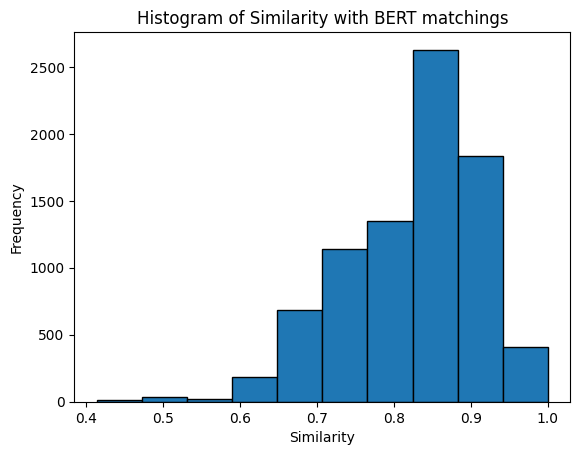

In [126]:
# distribution of similarity scores
import matplotlib.pyplot as plt
plt.hist(nodes['similarity_of_best_match'], bins=10, edgecolor='black')
plt.title('Histogram of Similarity with BERT matchings')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()


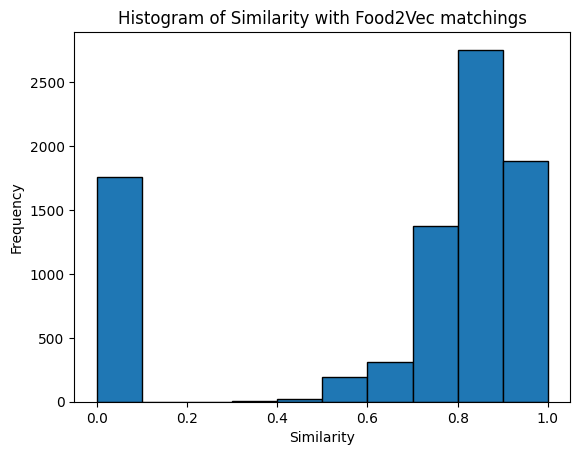

In [127]:
# distribution of similarity scores
import matplotlib.pyplot as plt
plt.hist(nodes_f2v['similarity_of_best_match'].fillna(0), bins=10, edgecolor='black')
plt.title('Histogram of Similarity with Food2Vec matchings')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()


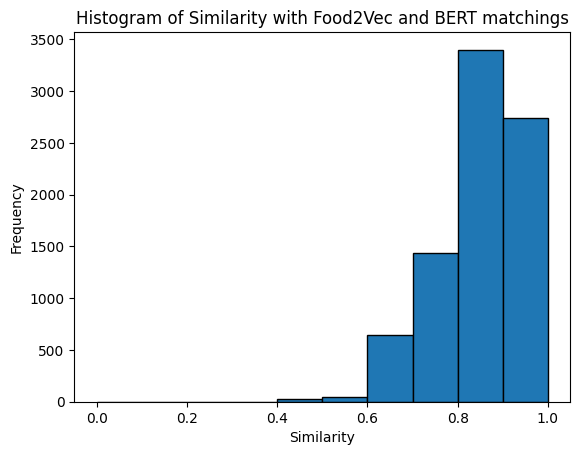

In [128]:
# distribution of similarity scores from joint data
import matplotlib.pyplot as plt
plt.hist(nodes_f2v['similarity_of_best_match_joint'].fillna(0), bins=10, edgecolor='black')
plt.title('Histogram of Similarity with Food2Vec and BERT matchings')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

## Exploration of the external data

In [129]:
# get list of columns ending with 'mg'
micro_columns_list = [element for element in nutri_data.columns if element.endswith('mg)')]

# get dataframe with subset of columns for micronutrients
df_micro = nutri_data[micro_columns_list]

# get summary statistics of micronutrient columns
pd.DataFrame(
	data={
		'average':df_micro.mean(),
		'standard_deviation':df_micro.std()
		}
)

,average,standard_deviation
Calcium_(mg),76.738214,203.527453
Iron_(mg),2.699674,5.687560
Magnesium_(mg),35.295988,57.416785
Phosphorus_(mg),165.142126,204.704214
Potassium_(mg),279.472740,375.483729
Sodium_(mg),312.495923,943.431341
Zinc_(mg),2.117438,3.437209
Copper_mg),0.195984,0.582596
Manganese_(mg),0.658156,7.248609
Vit_C_(mg),9.231134,68.854696
